# Actividad 2.3a - Embeddings

## Integrantes:

A01753729 Marco Antonio Caudillo Morales

A01747327 Jorge Daniel Rea Prado

A01753911 Oswaldo Daniel Hernández De Luna

A01754412 Adolfo Sebastian Gonzalez Mora

## Propuesta
Utilizar embeddings para la identificación de patrones relacionados con la anorexia porque te permiten capturar el significado contextual y las relaciones semánticas profundas entre palabras, más allá de simples coincidencias léxicas. Esto con el fin de tener en cuenta el contexto de las palabras para dar con el resultado con acertividad según el contexto de las palabras.

Lo que proponemos es ocupar embeddings para darles pesos a las palabras que tengan más relacion con la anorexia y poder identificar a los individuos con estos desordenes alimenticios.

In [14]:
import pandas as pd
import gensim
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
import nltk
import numpy as np

nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/davidclemente/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/davidclemente/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [15]:
import re
#Esta función limpia el texto eliminando URLs, menciones, signos, números y stopwords, además de convertirlo a minúsculas y tokenizarlo.

def limpiar_tokens(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    text = re.sub(r"\@\w+|\#|\d+", '', text)
    text = re.sub(r"[^\w\s]", '', text)
    tokens = word_tokenize(text)
    return [word for word in tokens if word not in stopwords.words('spanish') and len(word) > 2]

In [16]:
#Cargar el archivo CSV, seleccionar la columna de texto, aplicar la función de limpieza
df = pd.read_csv('../data/data_train.csv')

text_column = "tweet_text" if "tweet_text" in df.columns else df.columns[0]

df['tokens'] = df[text_column].apply(limpiar_tokens)
df[['tokens']].head()

,tokens
0,"[cheesecake, saludable, azúcar, lactosa, merme..."
1,"[ser, hastaloshuesos]"
2,"[comida, real, clave, sana, delgada, feliz]"
3,"[cambio, hora, bajada, temperaturas, destempla..."
4,"[hace, tiempo, sentía, cuerpo, tan, frío]"


In [17]:
def limpiar_texto(text):
    tokens = limpiar_tokens(text)
    return ' '.join(tokens)

df['texto_limpio'] = df[text_column].apply(limpiar_texto)

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(ngram_range=(1, 3), min_df=2, max_features=5000)

X = vectorizer.fit_transform(df['texto_limpio'])

In [19]:
df['label'] = df['class'].apply(lambda x: 1 if x == 'anorexia' else 0)

In [20]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

xgb_clf = xgb.XGBClassifier(
    objective='binary:logistic',
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

In [21]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 0.2]
}

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

grid_search = GridSearchCV(
    estimator=xgb_clf,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=3,
    verbose=2,
    n_jobs=-1
)

y = df['label']

# Separar datos (usa X e y ya definidos con TF-IDF y labels binarios)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 96 candidates, totalling 288 fits


/opt/anaconda3/envs/marco/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:05:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/marco/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:05:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/marco/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:05:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/marco/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:05:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are

[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.8; total time=   0.1s


/opt/anaconda3/envs/marco/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:05:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/marco/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:05:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/marco/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:05:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/marco/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:05:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are

[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=1.0; total time=   0.2s


/opt/anaconda3/envs/marco/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:05:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/marco/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:05:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/marco/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:05:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/marco/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:05:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are

[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] EN

/opt/anaconda3/envs/marco/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:05:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/marco/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:05:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/marco/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:05:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/marco/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:05:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are

[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=7, n_estimators=200, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] EN

/opt/anaconda3/envs/marco/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:05:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/marco/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:05:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/marco/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:05:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/marco/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:05:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are

[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=7, n_estimators=200, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=7, n_estimators=200, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=7, n_estimators=200, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=7, n_estimators=200, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=7, n_estimators=200, subsample=1.0; total time=   0.2s

/opt/anaconda3/envs/marco/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:05:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/marco/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:05:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/marco/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:05:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/marco/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:05:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are

[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=1.0; tot

/opt/anaconda3/envs/marco/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:05:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/marco/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:05:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/marco/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:05:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/marco/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:05:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are

[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=7, n_estimators=200, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=7, n_estimators=200, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=1.0; total tim

/opt/anaconda3/envs/marco/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:05:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/marco/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:05:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/marco/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:05:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/marco/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:05:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are

[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   0

/opt/anaconda3/envs/marco/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:05:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/marco/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:05:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/marco/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:05:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/marco/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:05:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are

[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=7, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=7, n_estimators=200, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=7, n_estimators=200, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.8; total time=   0.

/opt/anaconda3/envs/marco/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:05:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/marco/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:05:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/marco/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:05:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/marco/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:05:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are

[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.8; total time=   0.3s
[C

/opt/anaconda3/envs/marco/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:05:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/marco/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:05:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/marco/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:05:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/marco/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:05:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are

[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=7, n_estimators=200, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=7, n_estimators=200, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=7, n_estimators=200, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=7, n_estimators=200, subsample=1.0; total time=   0.4s
[CV]

/opt/anaconda3/envs/marco/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:05:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/marco/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:05:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/marco/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:05:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/marco/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:05:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are

[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=1.0; tot

/opt/anaconda3/envs/marco/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:05:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/marco/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:05:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/marco/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:05:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/marco/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:05:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are

[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=7, n_estimators=200, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=7, n_estimators=200, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=7, n_estimators=200, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.8; total time= 

/opt/anaconda3/envs/marco/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:05:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/marco/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:05:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/marco/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:05:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/marco/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:05:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are

[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=1.0; total tim

/opt/anaconda3/envs/marco/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:05:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/marco/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:05:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/marco/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:05:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/marco/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:05:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are

[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=7, n_estimators=200, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=7, n_estimators=200, subsample=1.0; total tim

/opt/anaconda3/envs/marco/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:05:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     feature_weights=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraint...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 1.0], 'gamma': [0, 0.2],
                         'learning_rate': [0.01, 0.1], 'max_depth': [3, 5, 7],
                         'n_estimators': [100, 200], 'subsample': [0.8, 1.0]},
             scoring='roc_auc', verbose=2)

In [23]:
print("Mejor AUC en validación cruzada:", grid_search.best_score_)
print("Mejores hiperparámetros:", grid_search.best_params_)

best_model = grid_search.best_estimator_

Mejor AUC en validación cruzada: 0.8992792792792793
Mejores hiperparámetros: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 1.0}


In [24]:
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

from sklearn.metrics import classification_report, roc_auc_score
print(classification_report(y_test, y_pred, target_names=["Control", "Anorexia"]))
print("AUC en test:", roc_auc_score(y_test, y_proba))

              precision    recall  f1-score   support

     Control       0.89      0.65      0.75       141
    Anorexia       0.75      0.93      0.83       159

    accuracy                           0.80       300
   macro avg       0.82      0.79      0.79       300
weighted avg       0.82      0.80      0.80       300

AUC en test: 0.9153173647352693


In [ ]:
feature_names = vectorizer.get_feature_names_out()

In [ ]:
importancia = best_model.feature_importances_

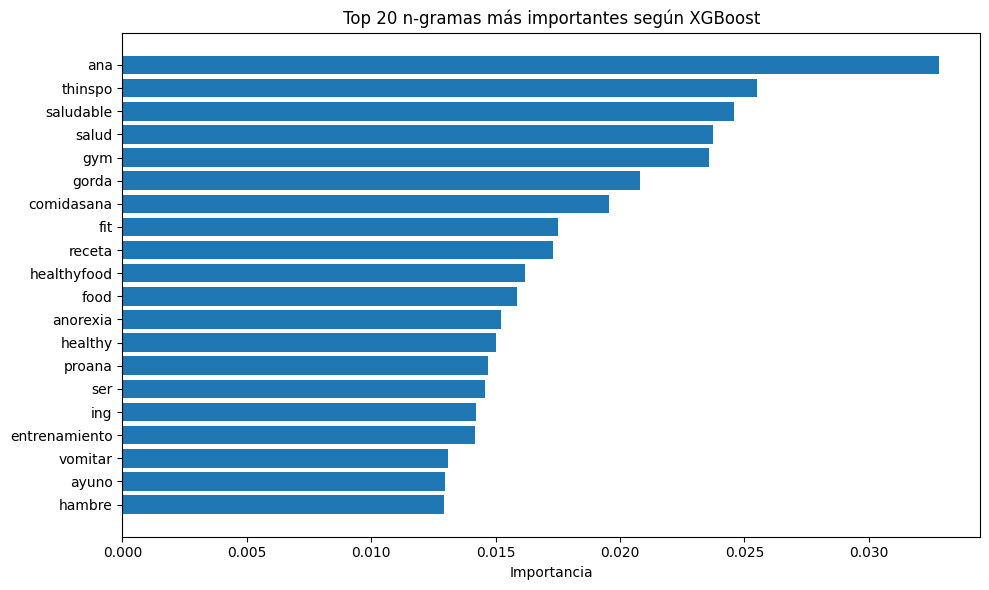

In [ ]:
import matplotlib.pyplot as plt

df_importancia = pd.DataFrame({
    'ngrama': feature_names,
    'importancia': importancia
})


df_importancia = df_importancia.sort_values(by='importancia', ascending=False).head(20)

plt.figure(figsize=(10, 6))
plt.barh(df_importancia['ngrama'], df_importancia['importancia'])
plt.gca().invert_yaxis()
plt.title("Top 20 n-gramas más importantes según XGBoost")
plt.xlabel("Importancia")
plt.tight_layout()
plt.show()

# Validación, Rango de polaridad

In [30]:
df_val = pd.read_csv('../data/data_test_fold1 - anorexia(in).csv')

In [31]:
df_val['tokens'] = df_val[text_column].apply(limpiar_tokens)

In [32]:
df_val['texto_limpio'] = df_val[text_column].apply(limpiar_texto)

In [33]:
X_val = vectorizer.transform(df_val['texto_limpio'])

In [34]:
# Asegura que tienes la columna 'class' con etiquetas como 'anorexia' o 'control'
df_val['label'] = df_val['class'].apply(lambda x: 1 if x.lower() == 'anorexia' else 0)
y_val = df_val['label']

In [35]:
# Usar el mejor modelo del grid search
y_pred_val = best_model.predict(X_val)
y_proba_val = best_model.predict_proba(X_val)[:, 1]

AUC en validación externa: 0.8927882141019042
              precision    recall  f1-score   support

     Control       0.87      0.64      0.74       116
    Anorexia       0.75      0.92      0.82       134

    accuracy                           0.79       250
   macro avg       0.81      0.78      0.78       250
weighted avg       0.80      0.79      0.78       250



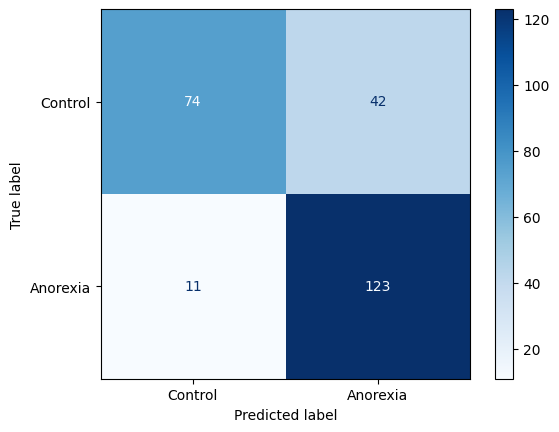

In [36]:
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

print("AUC en validación externa:", roc_auc_score(y_val, y_proba_val))
print(classification_report(y_val, y_pred_val, target_names=["Control", "Anorexia"]))

# Matriz de confusión
cm = confusion_matrix(y_val, y_pred_val)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Control", "Anorexia"])
disp.plot(cmap='Blues')